Define the device:

In [1]:
import os
import torch
import warnings
warnings.filterwarnings('ignore')

gpu_list = [7]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the `Hist2Cell` model:

In [2]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    def __init__(self, cell_dim=80, vit_depth=3):
        super(Hist2Cell, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
    
    
    def forward(self, x, edge_index):
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        x_spot = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot)
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        cell_prediction_fused = self.fused_head((x_spot+x_local+x_global)/3.0)
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

Load the checkpoint weights in the Leave-A50-out experiments for human lung cell2location dataset:

In [3]:
case = "A50"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("./model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

Load test split file, there are 2 slides from donor A50 in humanlung cell2location dataset: 
- WSA_LngSP9258463
- WSA_LngSP9258467

In [4]:
test_slides = open("./train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['WSA_LngSP9258463', 'WSA_LngSP9258467']

Load and create the `Dataloader` for the processed data of each slide, save the predictions and calculate the pearson R for 80 fine-grained cell types:

In [5]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("./example_data/humanlung_cell2location", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 51/51 [00:05<00:00,  8.53it/s]

slide WSA_LngSP9258463 has PCC:0.283839
slide WSA_LngSP9258467 has PCC:0.367423


In [6]:
Predictions.keys()

dict_keys(['WSA_LngSP9258463', 'WSA_LngSP9258467'])

Under the prediction of each slide, we have the labels and predictions for the 80 fine-grained cell types of each spot, and the spatial coordinate of each spot:

In [7]:
Predictions['WSA_LngSP9258463'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

Next, we show key cell types with high Pearson R (above 0.61) and low Jensen–Shannon divergence (lower than 0.32), the generated figures are used in Fig 2.d in our paper:

First, we define the plot function adopted from `Cell2location` repository:

In [8]:
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 
import numpy as np
from scipy.spatial.distance import jensenshannon
from tkinter import font


def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Cell2location cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True):
    
    plt.rcParams.update({'font.size': 14})  # Increase font size
    cor = np.round(np.corrcoef(cell_count.flatten(), infer_cell_count.flatten()), 3)[0,1]
    max_val = np.concatenate([cell_count.flatten(), infer_cell_count.flatten()]).max()
    title = title +'\n'+ r'Pearson R: ' + str(cor)
    
    if compute_kl:
        js = np.array([jensenshannon(cell_count[r,:], infer_cell_count[r,:]) 
                 for r in range(cell_count.shape[0])])
        js = np.mean(js[~np.isnan(js)])
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))

    if np.max(cell_count) > 1:
        x_bins = int(np.max(cell_count))
        max_val = np.max(cell_count) 
    else:
        x_bins = 35
        max_val = np.max(cell_count)

    fig, ax = plt.subplots()
    h = ax.hist2d(x=cell_count.flatten(), 
                  y=infer_cell_count.flatten(),
                  bins=[x_bins, 35], 
                  norm=matplotlib.colors.LogNorm())

    plt.xlabel(xlab, fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=10)  
    ax.tick_params(axis='y', labelsize=10)  
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.title(title, fontsize=10)
    
    cbar = plt.colorbar(h[3], ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('Frequency', fontsize=10)

    plt.show()
    plt.close()

Load the cell type names for our 80 fine-grained cell types:

In [9]:
import joblib


cell_types = joblib.load("./example_data/humanlung_cell2location/cell_types.pkl")
cell_types[:5]

['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA']

Next, we generate the key cell types performance used in `Fig.2e` in our paper:

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 200x200 with 0 Axes>

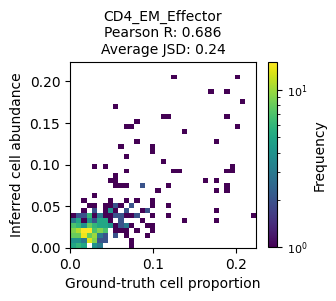

 25%|██▌       | 1/4 [00:00<00:00,  4.07it/s]

<Figure size 200x200 with 0 Axes>

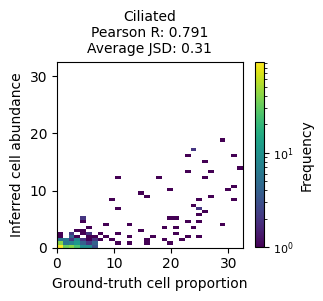

 50%|█████     | 2/4 [00:00<00:00,  5.27it/s]

<Figure size 200x200 with 0 Axes>

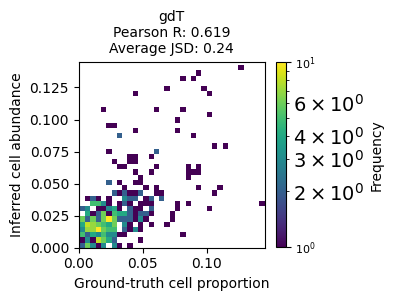

 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

<Figure size 200x200 with 0 Axes>

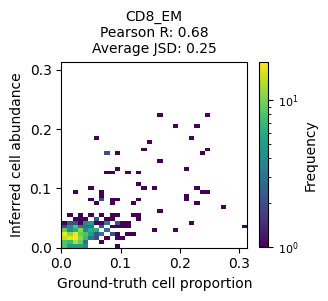

100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


In [10]:
key_cell_types = ['CD4_EM_Effector', 'Ciliated', 'gdT', 'CD8_EM']

slide = 'WSA_LngSP9258463'

hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
ground_truth_abundances = Predictions[slide]['cell_abundance_labels']

for i in tqdm(range(len(key_cell_types))):
    plt.figure(figsize=(2, 2))    
    cell_idx = cell_types.index(key_cell_types[i])
    x = hist2cell_abundances[:, [cell_idx]]
    x = np.expand_dims(x, axis=0)
    y = ground_truth_abundances[:,[cell_idx]]
    y = np.expand_dims(y, axis=0)
    rcParams['figure.figsize'] = 3, 3
    rcParams["axes.facecolor"] = "white"
    
    hist_obs_sim(cell_count=y, infer_cell_count=x, equal=True, title=key_cell_types[i], xlab='Ground-truth cell proportion', ylab='Inferred cell abundance')